# Capacitated Vehicle Routing Problem (CVRP) with Column Generation

This notebook demonstrates how to solve the **Capacitated Vehicle Routing Problem (CVRP)** using the OpenCG column generation framework.

## Problem Description

Given:
- A depot location
- $n$ customers with locations and demands
- Vehicles with capacity $Q$

Find routes for vehicles to:
- Visit every customer exactly once
- Respect vehicle capacity constraints
- Minimize total travel distance

## Column Generation Approach

**Master Problem**: Select routes to minimize total distance
- Each column (route) visits a subset of customers
- Set partitioning constraint: each customer in exactly one route

**Pricing Problem**: Find routes with negative reduced cost
- Shortest Path Problem with Resource Constraints (SPPRC)
- Resources: capacity (cumulative demand), visited customers (elementarity)

In [1]:
import sys
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent.parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from opencg.applications.vrp import (
    CVRPInstance,
    CVRPConfig,
    CVRPSolution,
    solve_cvrp,
)

import matplotlib.pyplot as plt
import numpy as np

## Example 1: Small Instance

Let's start with a small instance to visualize the problem and solution.

In [2]:
# Create a simple instance: depot at center, customers around it
instance = CVRPInstance(
    depot=(50, 50),
    customers=[
        (20, 70),   # Customer 0: northwest
        (80, 70),   # Customer 1: northeast
        (80, 30),   # Customer 2: southeast
        (20, 30),   # Customer 3: southwest
        (50, 90),   # Customer 4: north
        (50, 10),   # Customer 5: south
    ],
    demands=[15, 20, 25, 10, 30, 20],  # Total: 120
    vehicle_capacity=50,
    name="small_vrp"
)

print(f"Instance: {instance.name}")
print(f"Depot: {instance.depot}")
print(f"Customers: {instance.num_customers}")
print(f"Total demand: {instance.total_demand}")
print(f"Vehicle capacity: {instance.vehicle_capacity}")
print(f"Min vehicles needed: {instance.min_vehicles}")
print()
print("Customers:")
for i in range(instance.num_customers):
    print(f"  {i}: location={instance.customers[i]}, demand={instance.demands[i]}")

Instance: small_vrp
Depot: (50, 50)
Customers: 6
Total demand: 120
Vehicle capacity: 50
Min vehicles needed: 3

Customers:
  0: location=(20, 70), demand=15
  1: location=(80, 70), demand=20
  2: location=(80, 30), demand=25
  3: location=(20, 30), demand=10
  4: location=(50, 90), demand=30
  5: location=(50, 10), demand=20


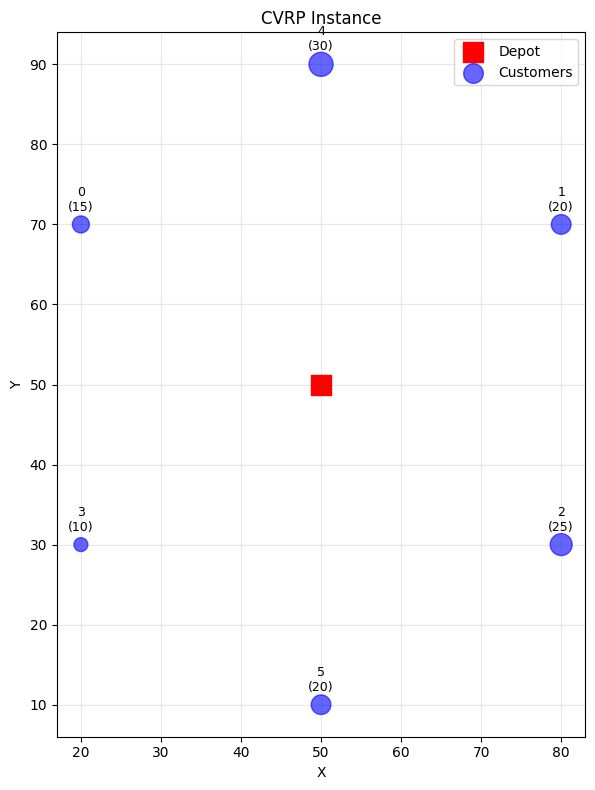

In [3]:
def visualize_instance(instance, title="CVRP Instance"):
    """Visualize customers and depot."""
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Plot depot
    ax.scatter(*instance.depot, s=200, c='red', marker='s', zorder=5, label='Depot')
    
    # Plot customers
    xs = [c[0] for c in instance.customers]
    ys = [c[1] for c in instance.customers]
    sizes = [d * 10 for d in instance.demands]  # Size proportional to demand
    
    ax.scatter(xs, ys, s=sizes, c='blue', alpha=0.6, zorder=4, label='Customers')
    
    # Label customers
    for i, (x, y) in enumerate(instance.customers):
        ax.annotate(f"{i}\n({instance.demands[i]})", (x, y), 
                   textcoords="offset points", xytext=(0, 10),
                   ha='center', fontsize=9)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(title)
    ax.legend()
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

visualize_instance(instance)

In [4]:
# Solve with column generation
config = CVRPConfig(verbose=True, max_iterations=50)
solution = solve_cvrp(instance, config)

Lower bound (capacity): 3 vehicles
Network: 9 nodes, 44 arcs
Greedy heuristic: 3 routes, cost=336.33

Column Generation:
 Iter    Objective  Columns   New
-----------------------------------
Running HiGHS 1.12.0 (git hash: 755a8e0): Copyright (c) 2025 HiGHS under MIT licence terms
LP has 6 rows; 9 cols; 12 nonzeros
Coefficient ranges:
  Matrix  [1e+00, 1e+00]
  Cost    [1e+02, 1e+06]
  Bound   [0e+00, 0e+00]
  RHS     [1e+00, 1e+00]
Presolving model
0 rows, 0 cols, 0 nonzeros  0s
0 rows, 0 cols, 0 nonzeros  0s
Presolve reductions: rows 0(-6); columns 0(-9); nonzeros 0(-12) - Reduced to empty
Performed postsolve
Solving the original LP from the solution after postsolve

Model status        : Optimal
Objective value     :  3.3633307653e+02
P-D objective error :  4.6746083214e-14
HiGHS run time      :          0.00
    0       336.33        9     5
LP has 6 rows; 14 cols; 19 nonzeros
Coefficient ranges:
  Matrix  [1e+00, 1e+00]
  Cost    [7e+01, 1e+06]
  Bound   [0e+00, 0e+00]
  RHS     [

In [5]:
# Show solution
print(f"\nSolution Summary:")
print(f"  Total distance (LP): {solution.total_distance:.2f}")
print(f"  Total distance (IP): {solution.total_distance_ip:.2f}")
print(f"  Vehicles used: {solution.num_vehicles}")
print(f"  Solve time: {solution.solve_time:.2f}s")
print(f"  CG iterations: {solution.iterations}")
print()
print("Routes:")
for i, route in enumerate(solution.routes):
    route_demand = sum(instance.demands[c] for c in route)
    print(f"  Route {i+1}: depot -> {route} -> depot (demand: {route_demand}/{instance.vehicle_capacity})")


Solution Summary:
  Total distance (LP): 330.28
  Total distance (IP): 336.33
  Vehicles used: 3
  Solve time: 0.00s
  CG iterations: 4

Routes:
  Route 1: depot -> [0, 4] -> depot (demand: 45/50)
  Route 2: depot -> [1, 2] -> depot (demand: 45/50)
  Route 3: depot -> [3, 5] -> depot (demand: 30/50)


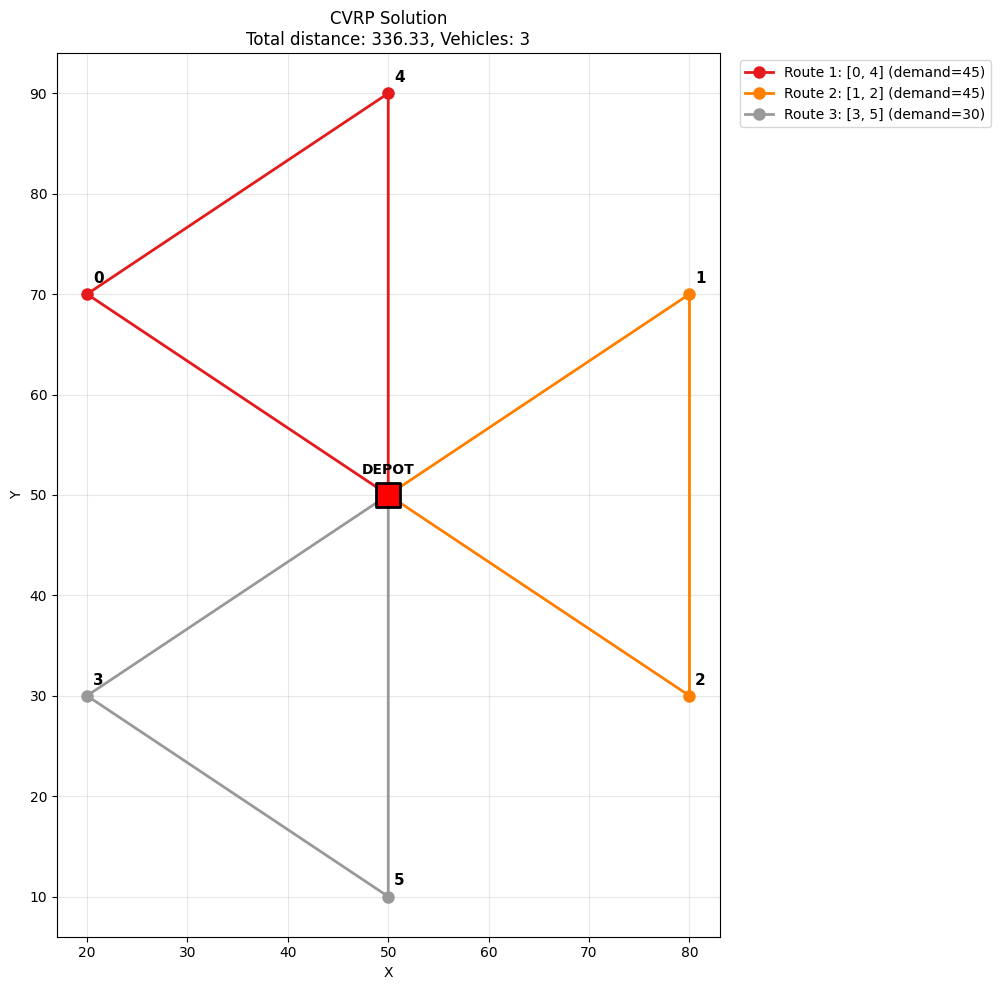

In [6]:
def visualize_solution(instance, solution, title="CVRP Solution"):
    """Visualize routes on the map."""
    fig, ax = plt.subplots(figsize=(10, 10))
    
    colors = plt.cm.Set1(np.linspace(0, 1, len(solution.routes)))
    
    # Plot routes
    for idx, route in enumerate(solution.routes):
        if not route:
            continue
        
        # Build path: depot -> customers -> depot
        path_x = [instance.depot[0]]
        path_y = [instance.depot[1]]
        
        for cust in route:
            path_x.append(instance.customers[cust][0])
            path_y.append(instance.customers[cust][1])
        
        path_x.append(instance.depot[0])
        path_y.append(instance.depot[1])
        
        route_demand = sum(instance.demands[c] for c in route)
        ax.plot(path_x, path_y, 'o-', color=colors[idx], linewidth=2, markersize=8,
               label=f'Route {idx+1}: {route} (demand={route_demand})')
    
    # Plot depot
    ax.scatter(*instance.depot, s=300, c='red', marker='s', zorder=10, edgecolors='black', linewidth=2)
    ax.annotate('DEPOT', instance.depot, textcoords="offset points", xytext=(0, 15),
               ha='center', fontsize=10, fontweight='bold')
    
    # Label customers
    for i, (x, y) in enumerate(instance.customers):
        ax.annotate(f"{i}", (x, y), textcoords="offset points", xytext=(8, 8),
                   ha='center', fontsize=11, fontweight='bold')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(f"{title}\nTotal distance: {solution.total_distance_ip:.2f}, Vehicles: {solution.num_vehicles}")
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

visualize_solution(instance, solution)

## Example 2: Random Instance

Let's solve a larger random instance to see how the algorithm scales.

Instance: random_12
Customers: 12
Total demand: 231
Vehicle capacity: 80
Min vehicles: 3


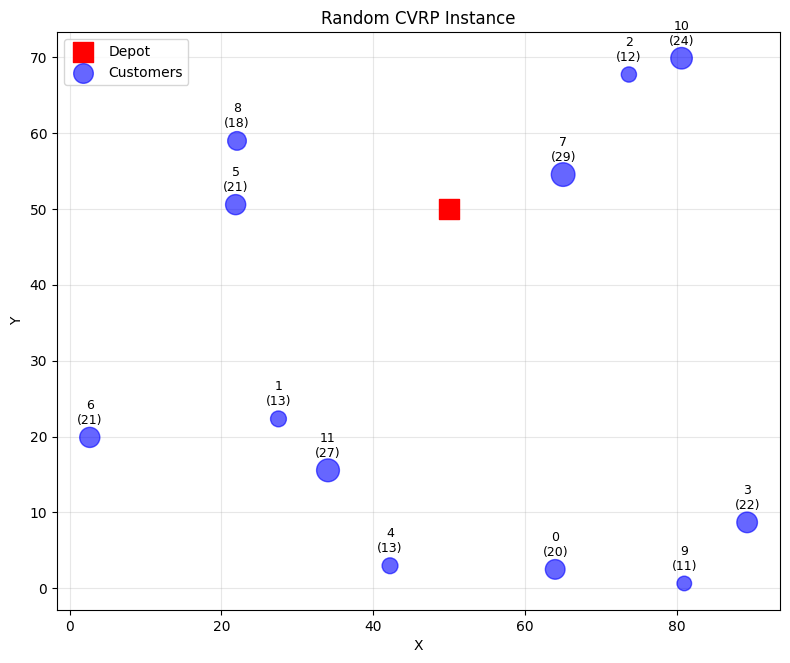

In [7]:
import random

# Generate random instance
random.seed(42)
n_customers = 12

customers = [(random.uniform(0, 100), random.uniform(0, 100)) for _ in range(n_customers)]
demands = [random.randint(10, 30) for _ in range(n_customers)]

instance = CVRPInstance(
    depot=(50, 50),
    customers=customers,
    demands=demands,
    vehicle_capacity=80,
    name="random_12"
)

print(f"Instance: {instance.name}")
print(f"Customers: {instance.num_customers}")
print(f"Total demand: {instance.total_demand}")
print(f"Vehicle capacity: {instance.vehicle_capacity}")
print(f"Min vehicles: {instance.min_vehicles}")

visualize_instance(instance, "Random CVRP Instance")

In [8]:
# Solve
config = CVRPConfig(verbose=True, max_iterations=100)
solution = solve_cvrp(instance, config)

print(f"\nSolution:")
print(f"  LP: {solution.total_distance:.2f}")
print(f"  IP: {solution.total_distance_ip:.2f}")
print(f"  Vehicles: {solution.num_vehicles}")
print(f"  Time: {solution.solve_time:.2f}s")

Lower bound (capacity): 3 vehicles
Network: 15 nodes, 158 arcs
Greedy heuristic: 3 routes, cost=525.85

Column Generation:
 Iter    Objective  Columns   New
-----------------------------------
Running HiGHS 1.12.0 (git hash: 755a8e0): Copyright (c) 2025 HiGHS under MIT licence terms
LP has 12 rows; 15 cols; 24 nonzeros
Coefficient ranges:
  Matrix  [1e+00, 1e+00]
  Cost    [1e+02, 1e+06]
  Bound   [0e+00, 0e+00]
  RHS     [1e+00, 1e+00]
Presolving model
0 rows, 0 cols, 0 nonzeros  0s
0 rows, 0 cols, 0 nonzeros  0s
Presolve reductions: rows 0(-12); columns 0(-15); nonzeros 0(-24) - Reduced to empty
Performed postsolve
Solving the original LP from the solution after postsolve

    0       525.85       15 Model status        : Optimal
Objective value     :  5.2584961528e+02
P-D objective error :  8.2357410293e-13
HiGHS run time      :          0.00
  100
LP has 12 rows; 115 cols; 376 nonzeros
Coefficient ranges:
  Matrix  [1e+00, 1e+00]
  Cost    [1e+02, 1e+06]
  Bound   [0e+00, 0e+00]
  

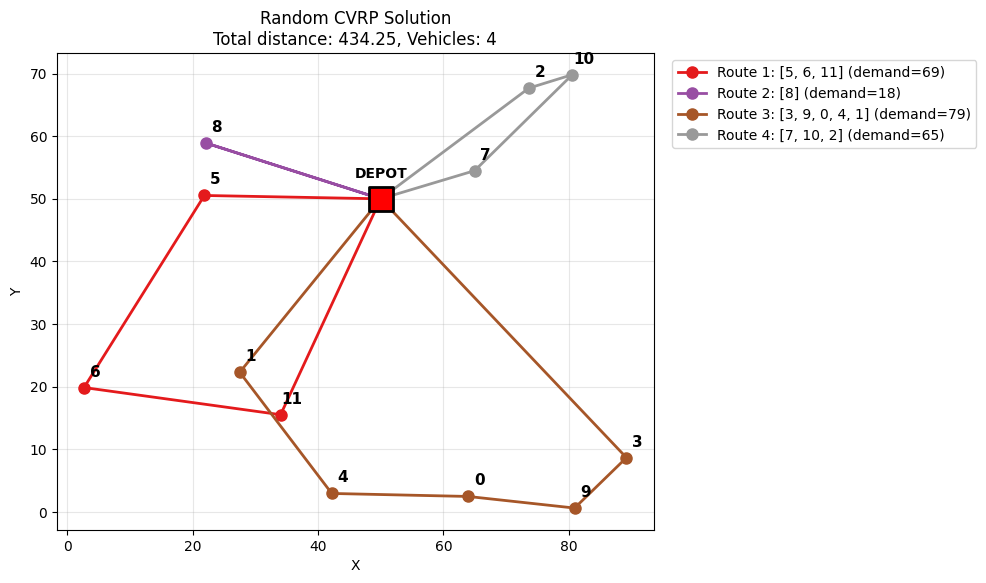

In [9]:
visualize_solution(instance, solution, "Random CVRP Solution")

## Understanding the Column Generation Process

### Network Structure

The VRP is solved on a network with:
- **Source node**: Artificial start
- **Depot node**: Physical depot location
- **Customer nodes**: One per customer
- **Sink node**: Artificial end

### Resources

1. **Capacity Resource**: Tracks cumulative demand on the vehicle
   - Starts at 0, increases by customer demand
   - Path is infeasible if exceeds vehicle capacity

2. **Elementarity**: Each customer visited at most once per route
   - Handled via `check_elementarity=True` in pricing config

### Pricing Problem (SPPRC)

Find shortest path from source to sink:
- Cost = actual travel distance - dual values for visited customers
- Negative reduced cost = improves the solution

In [10]:
# Let's trace the column generation on a tiny instance
instance = CVRPInstance(
    depot=(0, 0),
    customers=[
        (10, 0),   # Customer 0: east
        (0, 10),   # Customer 1: north
        (-10, 0),  # Customer 2: west
    ],
    demands=[30, 25, 20],  # Total: 75
    vehicle_capacity=50,  # Need at least 2 vehicles
    name="tiny_vrp"
)

print(f"Instance: {instance}")
print(f"Min vehicles: {instance.min_vehicles}")

# Solve with verbose output
config = CVRPConfig(verbose=True, max_iterations=20)
solution = solve_cvrp(instance, config)

Instance: CVRPInstance(name='tiny_vrp', customers=3, capacity=50, total_demand=75)
Min vehicles: 2
Lower bound (capacity): 2 vehicles
Network: 6 nodes, 14 arcs
Greedy heuristic: 2 routes, cost=60.00

Column Generation:
 Iter    Objective  Columns   New
-----------------------------------
Running HiGHS 1.12.0 (git hash: 755a8e0): Copyright (c) 2025 HiGHS under MIT licence terms
LP has 3 rows; 5 cols; 6 nonzeros
Coefficient ranges:
  Matrix  [1e+00, 1e+00]
  Cost    [2e+01, 1e+06]
  Bound   [0e+00, 0e+00]
  RHS     [1e+00, 1e+00]
Presolving model
    0        60.00        5     2
0 rows, 0 cols, 0 nonzeros  0s
0 rows, 0 cols, 0 nonzeros  0s
Presolve reductions: rows 0(-3); columns 0(-5); nonzeros 0(-6) - Reduced to empty
Performed postsolve
Solving the original LP from the solution after postsolve

Model status        : Optimal
Objective value     :  6.0000000000e+01
P-D objective error :  0.0000000000e+00
HiGHS run time      :          0.00
LP has 3 rows; 7 cols; 9 nonzeros
Coefficient 

In [11]:
# Verify solution
print("\nSolution verification:")
all_customers = set()
for i, route in enumerate(solution.routes):
    route_demand = sum(instance.demands[c] for c in route)
    print(f"Route {i+1}: {route}")
    print(f"  Demand: {route_demand}/{instance.vehicle_capacity}")
    print(f"  Feasible: {route_demand <= instance.vehicle_capacity}")
    for c in route:
        all_customers.add(c)

print(f"\nAll customers covered: {all_customers == set(range(instance.num_customers))}")


Solution verification:
Route 1: [2, 1]
  Demand: 45/50
  Feasible: True
Route 2: [0]
  Demand: 30/50
  Feasible: True

All customers covered: True


## Comparison: Greedy vs Column Generation

The solver starts with greedy nearest-neighbor routes. Let's compare the improvement.

In [12]:
# Generate a medium instance
random.seed(123)
n = 10

instance = CVRPInstance(
    depot=(50, 50),
    customers=[(random.uniform(10, 90), random.uniform(10, 90)) for _ in range(n)],
    demands=[random.randint(10, 25) for _ in range(n)],
    vehicle_capacity=60,
    name="comparison_test"
)

print(f"Instance: {n} customers, total demand: {instance.total_demand}")
print(f"Min vehicles: {instance.min_vehicles}")

# Solve
config = CVRPConfig(verbose=True, max_iterations=50)
solution = solve_cvrp(instance, config)

Instance: 10 customers, total demand: 171
Min vehicles: 3
Lower bound (capacity): 3 vehicles
Network: 13 nodes, 112 arcs
Greedy heuristic: 3 routes, cost=305.46

Column Generation:
 Iter    Objective  Columns   New
-----------------------------------
Running HiGHS 1.12.0 (git hash: 755a8e0): Copyright (c) 2025 HiGHS under MIT licence terms
LP has 10 rows; 13 cols; 20 nonzeros
Coefficient ranges:
  Matrix  [1e+00, 1e+00]
  Cost    [5e+01, 1e+06]
  Bound   [0e+00, 0e+00]
  RHS     [1e+00, 1e+00]
Presolving model
0 rows, 0 cols, 0 nonzeros  0s
0 rows, 0 cols, 0 nonzeros  0s
Presolve reductions: rows 0(-10); columns 0(-13); nonzeros 0(-20) - Reduced to empty
Performed postsolve
Solving the original LP from the solution after postsolve
    0       305.46       13 
   51
Model status        : Optimal
Objective value     :  3.0546257495e+02
P-D objective error :  1.3088590523e-12
HiGHS run time      :          0.00
LP has 10 rows; 64 cols; 138 nonzeros
Coefficient ranges:
  Matrix  [1e+00, 1e

In [13]:
# The verbose output shows iteration 0 objective (greedy) vs final objective
print(f"\nImprovement from column generation:")
print(f"  Final LP: {solution.total_distance:.2f}")
print(f"  Final IP: {solution.total_distance_ip:.2f}")
print(f"  Columns generated: {solution.num_columns}")
print(f"  Iterations: {solution.iterations}")


Improvement from column generation:
  Final LP: 291.90
  Final IP: 291.90
  Columns generated: 107
  Iterations: 5


## Summary

Key concepts demonstrated:

1. **CVRP Structure**: Depot, customers with demands, vehicle capacity
2. **Set Partitioning**: Each customer in exactly one route
3. **SPPRC Pricing**: Find routes with negative reduced cost
4. **Resource Constraints**: Capacity limits route length
5. **Elementarity**: Each customer visited once per route

The CVRP solver in OpenCG:
- Uses nearest-neighbor heuristic for initial routes
- Labeling algorithm for SPPRC pricing
- Handles capacity and elementarity constraints
- Returns both LP and IP solutions